In [73]:
import model
import options
import assetmodel

In [74]:
import pandas as pd
import numpy as np

In [75]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [76]:
TRAINING_DATE_START = pd.to_datetime('2017-03-27')
TRAINING_DATE_END = pd.to_datetime('2018-03-27')

TEST_DATE_START = pd.to_datetime('2018-03-28')
TEST_DATE_END = pd.to_datetime('2018-12-27')

RISK_FREE_R = 0.03
WIG_20 = np.array(["ACP","CDR","JSW","LTS","PEO","PKN","SPL","ALE","CPS","KGH","MRC","PGE","PKO","TPE","CCC","DNP","LPP","OPL","PGN","PZU"])

In [77]:
def ReadAndPreprocess(url, ticker):
    data = pd.read_csv(url)
    data['Data'] = pd.to_datetime(data['Data'])
    data['Zwroty_dzienne'] = data['Zamkniecie'].pct_change()
    # log (S_{t+1} / S_t)
    data['Log_ratio'] = np.log(data['Zamkniecie']/ data['Zamkniecie'].shift(1))
    data['Company'] = ticker
    return data
  

def ReadWig20DailyPrices(url_prefix = 'https://raw.githubusercontent.com/wfica/stochastic-fin-maths/main/notowania_wig_20/',):
    df = pd.DataFrame()
    for company in WIG_20:
        url = url_prefix + company[:3].lower() + '_d.csv'
        data = ReadAndPreprocess(url, company)
        df = df.append(data, ignore_index=True)
    data = ReadAndPreprocess(url_prefix +'wig20_d.csv', 'W20')
    df = df.append(data, ignore_index=True)
    return df


wig_20_all = ReadWig20DailyPrices()

In [78]:
wigTraining = wig_20_all.loc[(wig_20_all['Data'] >= TRAINING_DATE_START) & (wig_20_all['Data'] < TRAINING_DATE_END) & (wig_20_all['Company'] == 'W20')]['Zamkniecie'].to_numpy()
kghmTraining = wig_20_all.loc[(wig_20_all['Data'] >= TRAINING_DATE_START) & (wig_20_all['Data'] < TRAINING_DATE_END) & (wig_20_all['Company'] == 'KGH')]['Zamkniecie'].to_numpy()

wigTest = wig_20_all.loc[(wig_20_all['Data'] >= TEST_DATE_START) & (wig_20_all['Data'] < TEST_DATE_END) & (wig_20_all['Company'] == 'W20')]['Zamkniecie'].to_numpy()
kghmTest = wig_20_all.loc[(wig_20_all['Data'] >= TEST_DATE_START) & (wig_20_all['Data'] < TEST_DATE_END) & (wig_20_all['Company'] == 'KGH')]['Zamkniecie'].to_numpy()



In [79]:
modelPrices = {"W20": wigTraining, "KGH": kghmTraining}

In [80]:
pricing = model.Model(modelPrices, RISK_FREE_R)

In [81]:
trajectories, rd = pricing.MonteCarloRealRN(int(0.75 * 250))

In [82]:
wigAOption = options.CallOption(wigTraining, 0.03, 2200)
wigAOption.update(2203.7, int(0.75*250))
print("Black scholes price:", wigAOption.value())

Black scholes price: 142.44418340470747


<Figure size 1440x720 with 0 Axes>

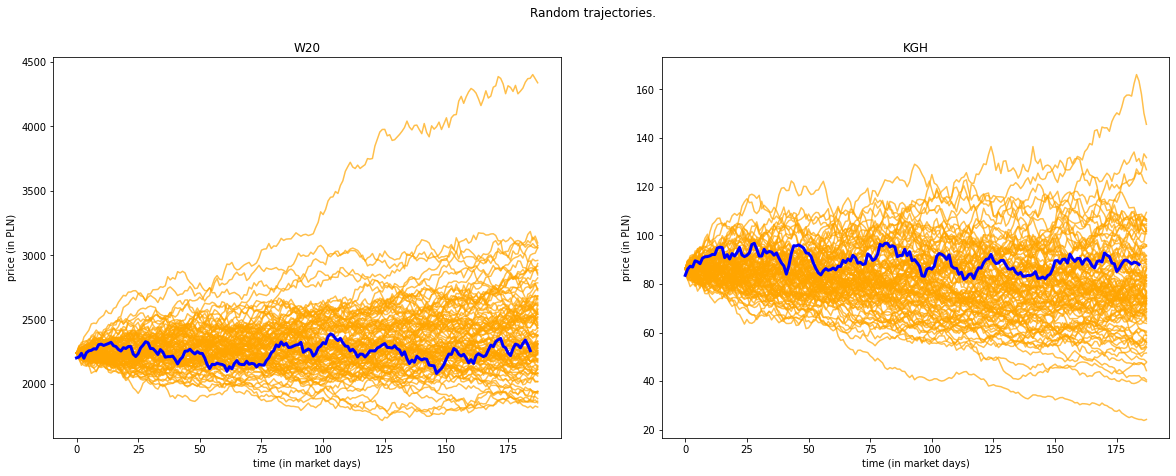

In [89]:
figure(figsize=(20, 10))
fig, axs = plt.subplots( 1,len(pricing.assets), figsize=(20, 7) )
fig.suptitle('Random trajectories.')
for ax in axs.flat:
    ax.set(xlabel='time (in market days)', ylabel='price (in PLN)')

s = 0
for _ in range(100):
    trajectories, rd = pricing.MonteCarloRealRN(int(0.75*250))
    s += wigAOption.payoff(trajectories[:,0])*rd/np.exp(0.03)
    for i in range(len(pricing.assets)):
        axs[i].plot(trajectories[:,i], c='orange', alpha=0.7)

for i, asset in enumerate(pricing.assets):
    axs[i].set_title(asset.name) 
    if asset.name == 'W20':
        axs[i].plot(wigTest,c='blue', linewidth=3.0)
    elif asset.name == 'KGH':
        axs[i].plot(kghmTest,c='blue', linewidth=3.0)

In [ ]:
pricing.assets[0].name

'wig20'

In [ ]:
s / 100.

156.92537063218006

In [ ]:
# zmiana parametrów model.changeAssetParameter("wig20", alpha = 0.01)
# # zmiana parametrów model.changeAssetParameter("wig20", alpha = 0.01, beta = 0.0000005)
model.getAssetParameters(name = "wig20")

,Name,alpha,beta
0,wig20,0.009626,0.00007


In [ ]:
model.getAssetParameters()

,Name,alpha,beta
0,wig20,0.009626,0.000070
1,kghm,0.019139,-0.001166
